In [1]:
from google.colab import files
uploaded = files.upload()

Saving spx.csv to spx (1).csv


In [2]:
import pandas as pd
import io

df = pd.read_csv(io.StringIO(uploaded['spx.csv'].decode('utf-8')))
df.head()

,Date,Open,High,Low,Close
0,12/31/19,3215.18,3231.72,3212.03,3230.78
1,12/30/19,3240.09,3240.92,3216.57,3221.29
2,12/27/19,3247.23,3247.93,3234.37,3240.02
3,12/26/19,3227.20,3240.08,3227.20,3239.91
4,12/24/19,3225.45,3226.43,3220.51,3223.38


In [3]:
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


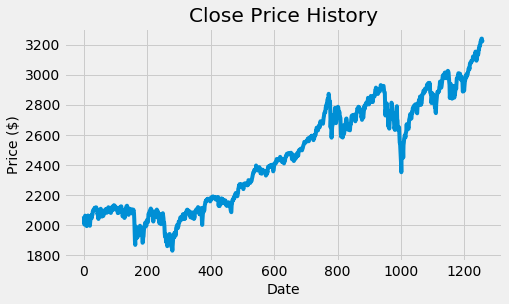

In [4]:
df['Close'] = df[' Close'].values[::-1]
plt.figure(figsize=(7,4))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price ($)',fontsize=14)
plt.show()

In [5]:
data = df.filter([' Close'])
data.iloc[:] = data.iloc[::-1].values
data = data.iloc[:]
dataset = data.values
training_data_len = math.ceil(len(dataset)*0.8)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i <= 61:
    print(x_train)
    print(y_train)
    print()

[array([0.1623882 , 0.13572512, 0.12298893, 0.13949566, 0.16518066,
       0.15289807, 0.1411683 , 0.13746155, 0.12912668, 0.11594398,
       0.13490297, 0.13712135, 0.14390406, 0.16589649, 0.15786639,
       0.16160149, 0.14208258, 0.12266999, 0.13619998, 0.11758827,
       0.13591648, 0.15659773, 0.1505592 , 0.16544998, 0.16045331,
       0.15426595, 0.16975208, 0.16970956, 0.18384907, 0.18988051,
       0.19225481, 0.19178704, 0.19020653, 0.19931393, 0.19886033,
       0.20298524, 0.20183707, 0.19962578, 0.1952032 , 0.20433895,
       0.19752789, 0.19097198, 0.19275093, 0.17164444, 0.1774349 ,
       0.15243738, 0.14965909, 0.16788099, 0.15898621, 0.1786823 ,
       0.17378485, 0.19165946, 0.18440898, 0.19775469, 0.1951465 ,
       0.18598948, 0.16440813, 0.16093526, 0.16438686, 0.18226147])]
[0.16925595702156015]

[array([0.1623882 , 0.13572512, 0.12298893, 0.13949566, 0.16518066,
       0.15289807, 0.1411683 , 0.13746155, 0.12912668, 0.11594398,
       0.13490297, 0.13712135, 0.14

In [6]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(947, 60, 1)

In [10]:
model = Sequential()
model.add(LSTM(40, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(30, return_sequences=False))
model.add(Dense(20)) 
model.add(Dense(1)) 

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
947/947 [==============================] - 69s 72ms/step - loss: 0.0024


In [11]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse 

3.312061986429286

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


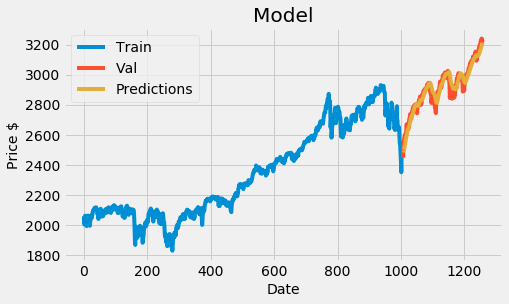

In [12]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(7,4))
plt.title('Model')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price $', fontsize=14)
plt.plot(train[' Close'])
plt.plot(valid[[' Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'upper left')